In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate, integrate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
import winsound
from pybamm import exp, constants, Parameter
import pickle
import scipy
eSOH_DIR = "../data/esoh_R/"
oCV_DIR = "../data/ocv/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_paper/"
res_DIR = "../data/results_paper/"
resistance_DIR = "../data/resistance/"
%matplotlib widget

In [2]:
parameter_values = get_parameter_values()

spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        "stress-induced diffusion": "false",
    }
)
# spm.print_parameter_info()
param=spm.param

In [3]:
cell = 4
sno = 12
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(cell_no)
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
        "Rest for 10 sec",
        "Charge at "+c_rate_c+" until 4.2V", 
        "Hold at 4.2V until C/100")
    ] *dfe.N.iloc[-1],
    # ] *40,
    termination="50% capacity",
#     cccv_handling="ode",
)

04


In [4]:
par_val = {}
# Previous i.e. tuning mech sim sep and then Li plating
par_val[0] = [1.2715e-07,1.2727e-06,1.1992,1.353e-9,0]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,x100,y0
par_val[1] = [1.4819e-07,1.5114e-06,1.2484,1.4732e-09,0]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[2] = [1.4493e-07,1.3608e-06,1.199,1.2138e-09,0]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,x100,y0
par_val[3] = [1.043e-07,1.036e-06,1.208,1.6045e-09,0]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[4] = [8.755e-08,8.572e-07,1.135,1.5788e-09,0]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%) another initial condition
par_val[5] = [8.7698e-08,8.5848e-07,1.1354,1.5778e-09,0]
# New Mech Damage Model
par_val[6] = [2.056E-07,2.4664E-06,1.2468,1.0482e-09,0]
# New Mech Damage Model with Lithium plating resistane
par_val[7] = [2.190e-07,2.308e-06,1.214,2.537e-09,0]
# New Assymetric Mech Damage Model, tuned using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging
par_val[8] = [1.426e-07,3.832e-06,1.215,2.35e-09,1.462e-06]
# New Assymetric Mech Damage Model, tuned using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging version 2
par_val[9] = [1.41036e-07,2.3913188000000003e-06,1.2098,2.4487124e-09,7.330208e-08]
# New Assymetric Mech Damage Model, tuned using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging version 3
par_val[10] = [1.414e-07,1.5045e-06,1.2094,2.45e-09,4.603e-08]
# Post processing LAM model using simulated stress, tuned using C/5 and 1.5C Cycling aging 
par_val[11] = [4.2298e-08,3.1590e-07,1.0773,2.3688e-09,1.8939e-08]
# Post processing LAM model using simulated stress, tuned using C/5 and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging 
par_val[12] = [8.4600e-09,2.8926e-07,1.0462,2.8351e-09,7.6933e-11]
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant proportional term 2 [s-1]": 0,
        "Negative electrode LAM constant proportional term 2 [s-1]": par_val[sno][4],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        "Negative electrode partial molar volume [m3.mol-1]": 4.544e-06,
        "Negative electrode LAM min stress [Pa]": 0,
        "Negative electrode LAM max stress [Pa]": 0,
        "Positive electrode LAM min stress [Pa]": 0,
        "Positive electrode LAM max stress [Pa]": 0,
        # "Li plating resistivity [Ohm.m]": 0,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)
if cell == 13 or cell == 16:
    parameter_values.update(
        {
            "Negative electrode partial molar volume [m3.mol-1]":	0.747*4.544e-06,
        },
        check_already_exists=False,
    ) 
# all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

In [5]:
model = spm
model1 = spm
SOC_0 = 1
save_at_cycles = 1
drive_cycle=None

experiment_one_cycle = pybamm.Experiment(
        experiment.operating_conditions_cycles[:1],
        termination=experiment.termination_string,
        cccv_handling=experiment.cccv_handling,
        drive_cycles={"DriveCycle": drive_cycle},
    )
Vmin = 3.0
Vmax = 4.2
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
param = model.param
esoh_solver = pybamm.lithium_ion.ElectrodeSOHSolver(parameter_values, param)
Cn = parameter_values.evaluate(param.n.cap_init)
Cp = parameter_values.evaluate(param.p.cap_init)
eps_n = parameter_values["Negative electrode active material volume fraction"]
eps_p = parameter_values["Positive electrode active material volume fraction"]
C_over_eps_n = Cn / eps_n
C_over_eps_p = Cp / eps_p
c_n_max = parameter_values.evaluate(param.n.prim.c_max)
c_p_max = parameter_values.evaluate(param.p.prim.c_max)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)

esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
    solver=pybamm.AlgebraicSolver(),
)

parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
            "x_100"
        ].data[0]
        * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
            "y_100"
        ].data[0]
        * c_p_max,
        
    }
)

parameter_values.update(
    {
        "Negative electrode LAM min stress [Pa]": 0,
        "Negative electrode LAM max stress [Pa]": 0,
        "Positive electrode LAM min stress [Pa]": 0,
        "Positive electrode LAM max stress [Pa]": 0,
    },
)

sim_ode = pybamm.Simulation(
    model, experiment=experiment_one_cycle, parameter_values=parameter_values,
    solver=pybamm.CasadiSolver("safe")
)
sim_ode1 = pybamm.Simulation(
    model, experiment=experiment_one_cycle, parameter_values=parameter_values,
    solver=pybamm.CasadiSolver("safe")
)
sol0 = sim_ode.solve(initial_soc=SOC_0)
model = sim_ode.solution.all_models[0]
# sol1 = sim_ode1.solve(initial_soc=SOC_0)
# model1 = sim_ode1.solution.all_models[0]
cap0 = sol0.summary_variables["Capacity [A.h]"]

In [6]:
def sol_to_y(sol, loc="end"):
    if loc == "start":
        pos = 0
    elif loc == "end":
        pos = -1
    model = sol.all_models[0]
    n_Li = sol["Total lithium in particles [mol]"].data[pos].flatten()
    Cn = sol["Negative electrode capacity [A.h]"].data[pos].flatten()
    Cp = sol["Positive electrode capacity [A.h]"].data[pos].flatten()
    # y = np.concatenate([n_Li, Cn, Cp])
    y = n_Li
    for var in model.initial_conditions:
        if var.name not in [
            "X-averaged negative particle concentration",
            "X-averaged positive particle concentration",
            "Discharge capacity [A.h]",
            "Porosity times concentration",
        ]:
            value = sol[var.name].data
            if value.ndim == 1:
                value = value[pos]
            elif value.ndim == 2:
                value = np.average(value[:, pos])
            elif value.ndim == 3:
                value = np.average(value[:, :, pos])
            y = np.concatenate([y, value.flatten()])
        elif var.name == "Porosity times concentration":
            for child in var.children:
                value = sol[child.name].data
                if value.ndim == 1:
                    value = value[pos]
                elif value.ndim == 2:
                    value = np.average(value[:, pos])
                elif value.ndim == 3:
                    value = np.average(value[:, :, pos])
                y = np.concatenate([y, value.flatten()])
    return y

In [7]:
def y_to_sol(y, esoh_sim, model):
    n_Li = y[0]
    Cn = C_over_eps_n * y[1]
    Cp = C_over_eps_p * y[2]

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    ics = {}
    x_100 = esoh_sol["x_100"].data[0]
    y_100 = esoh_sol["y_100"].data[0]
    x_0 = esoh_sol["x_0"].data[0]
    y_0 = esoh_sol["y_0"].data[0]
    start = 1
    for var in model.initial_conditions:
        if var.name == "X-averaged negative particle concentration":
            ics[var.name] = ((x_100-x_0)*SOC_0+x_0) * np.ones((model.variables[var.name].size, 2))
        elif var.name == "X-averaged positive particle concentration":
            ics[var.name] = ((y_100-y_0)*SOC_0+y_0)  * np.ones((model.variables[var.name].size, 2))
        elif var.name == "Discharge capacity [A.h]":
            ics[var.name] = np.zeros(1)
        else:
            if var.name == "Porosity times concentration":
                for child in var.children:
                    # end = start + model.variables[child.name].size
                    # ics[child.name] = y[start:end, np.newaxis]
                    end = start + 1
                    ics[child.name] = y[start] * np.ones((model.variables[var.name].size, 1))
                    start = end
            else:
                # end = start + model.variables[var.name].size
                # ics[var.name] = y[start:end, np.newaxis]
                end = start + 1
                ics[var.name] = y[start] * np.ones((model.variables[var.name].size, 1))
                start = end
    model.set_initial_conditions_from(ics)
    return pybamm.Solution(
        [np.array([0])],
        model.concatenated_initial_conditions.evaluate()[:, np.newaxis],
        model,
        {},
    )

In [8]:
def dydt(t, y):
    if y[0] < 0 or y[1] < 0 or y[2] < 0:
        return 0 * y

    # print(t)
    # Set up based on current value of y
    y_to_sol(
        y,
        esoh_sim,
        sim_ode.op_conds_to_built_models[
            experiment_one_cycle.operating_conditions[0]["electric"]
        ],
    )

    # Simulate one cycle
    sol = sim_ode.solve()

    dy = sol_to_y(sol) - y

    return dy

In [9]:
if experiment.termination == {}:
        event = None
else:

    def capacity_cutoff(t, y):
        sol = y_to_sol(y, esoh_sim, model)
        cap = pybamm.make_cycle_solution([sol], esoh_solver, True)[1]["Capacity [A.h]"]
        return cap / cap0 - experiment_one_cycle.termination["capacity"][0] / 100

    capacity_cutoff.terminal = True

num_cycles = len(experiment.operating_conditions_cycles)
if save_at_cycles is None:
    t_eval = np.arange(1, num_cycles + 1)
elif save_at_cycles == -1:
    t_eval = None
else:
    t_eval = np.arange(1, num_cycles + 1, save_at_cycles)
y0 = sol_to_y(sol0, loc="start")

In [10]:
y = y0
# print(t)
# Set up based on current value of y

y_to_sol(
    y,
    esoh_sim,
    sim_ode.op_conds_to_built_models[
        experiment_one_cycle.operating_conditions[0]["electric"]
    ],
)

# Simulate one cycle
sol = sim_ode.solve()
dy = sol_to_y(sol) - y
# print(dy)
t =  sol["Time [s]"].entries
t = t/3600
sigma_ts_n = sol["X-averaged negative particle surface tangential stress [Pa]"].entries
sigma_rs_n = sol["X-averaged negative particle surface radial stress [Pa]"].entries
sigma_hs_n = (sigma_rs_n+2*sigma_ts_n)/2
sigma_ts_p = sol["X-averaged positive particle surface tangential stress [Pa]"].entries
sigma_rs_p = sol["X-averaged positive particle surface radial stress [Pa]"].entries
sigma_hs_p = (sigma_rs_p+2*sigma_ts_p)/2

parameter_values.update(
    {
        "Negative electrode LAM min stress [Pa]": min(sigma_hs_n),
        "Negative electrode LAM max stress [Pa]": max(sigma_hs_n),
        "Positive electrode LAM min stress [Pa]": min(sigma_hs_p),
        "Positive electrode LAM max stress [Pa]": max(sigma_hs_p),
    },
)

sim_ode1 = pybamm.Simulation(
    spm, experiment=experiment_one_cycle, parameter_values=parameter_values,
    solver=pybamm.CasadiSolver("safe")
)
sol1 = sim_ode1.solve(initial_soc=SOC_0)
# model1 = sim_ode1.solution.all_models[0]

y_to_sol(
    y,
    esoh_sim,
    sim_ode1.op_conds_to_built_models[
        experiment_one_cycle.operating_conditions[0]["electric"]
    ],
)

# # Simulate one cycle
sol = sim_ode1.solve()
dy1 = sol_to_y(sol) - y
# print(dy1)

In [11]:
dnli = dy[0]
beta_LAM_n = param.n.beta_LAM_dimensional
beta_LAM2_n = param.n.beta_LAM_dimensional2
m_LAM_n = param.n.m_LAM
stress_critical_n = param.n.stress_critical_dim
j_stress_LAM_n = parameter_values.evaluate(-beta_LAM_n*(abs(min(sigma_hs_n)) / stress_critical_n) ** m_LAM_n + beta_LAM2_n*(abs(max(sigma_hs_n)) / stress_critical_n) ** m_LAM_n)
act_n_loss = j_stress_LAM_n*t[-1]*3600
C_n_loss = parameter_values.evaluate(act_n_loss*(param.n.L * param.n.prim.c_max * param.F* param.A_cc)/3600)
dCn = act_n_loss+dy[1]
c_save_n1 = sol["R-averaged negative particle concentration"].entries
c_save_n = c_save_n1[1,:]
dnli += parameter_values.evaluate(3600/param.F)*C_n_loss*np.average(c_save_n)
beta_LAM_p = param.p.beta_LAM_dimensional
beta_LAM2_p = param.p.beta_LAM_dimensional2
m_LAM_p = param.p.m_LAM
stress_critical_p = param.p.stress_critical_dim
j_stress_LAM_p = parameter_values.evaluate(-beta_LAM_p*(abs(min(sigma_hs_p)) / stress_critical_p) ** m_LAM_p + beta_LAM2_p*(abs(max(sigma_hs_p)) / stress_critical_p) ** m_LAM_p)
act_p_loss = j_stress_LAM_p*t[-1]*3600
C_p_loss = parameter_values.evaluate(act_p_loss*(param.p.L * param.p.prim.c_max * param.F* param.A_cc)/3600)
dCp = act_p_loss+dy[1]
c_save_p1 = sol["R-averaged positive particle concentration"].entries
c_save_p = c_save_p1[1,:]
dnli += parameter_values.evaluate(3600/param.F)*C_p_loss*np.average(c_save_p)
dy2 = np.zeros(6)
dy2[0] = dnli
dy2[1] = dCn
dy2[2] = dCp
dy2[3] = dy[3]
dy2[4] = dy[4]
dy2[5] = dy[5]


In [12]:
print(dy)
print(dy1)
print(dy2)

[-8.94748121e-05  0.00000000e+00  0.00000000e+00  4.43190705e-02
  6.22663845e-03  0.00000000e+00]
[-2.09356232e-04 -6.20268763e-04 -2.04306159e-05  4.43053867e-02
  6.23062760e-03  0.00000000e+00]
[-2.08635533e-04 -6.20330050e-04 -2.04326346e-05  4.43190705e-02
  6.22663845e-03  0.00000000e+00]


In [13]:
# sdfsdf

In [14]:
def dydt1(t, y):
    y = y0
    # print(t)
    # Set up based on current value of y

    y_to_sol(
        y,
        esoh_sim,
        sim_ode.op_conds_to_built_models[
            experiment_one_cycle.operating_conditions[0]["electric"]
        ],
    )

    # Simulate one cycle
    sol = sim_ode.solve()
    dy = sol_to_y(sol) - y
    # print(dy)
    t =  sol["Time [s]"].entries
    t = t/3600
    sigma_ts_n = sol["X-averaged negative particle surface tangential stress [Pa]"].entries
    sigma_rs_n = sol["X-averaged negative particle surface radial stress [Pa]"].entries
    sigma_hs_n = (sigma_rs_n+2*sigma_ts_n)/2
    sigma_ts_p = sol["X-averaged positive particle surface tangential stress [Pa]"].entries
    sigma_rs_p = sol["X-averaged positive particle surface radial stress [Pa]"].entries
    sigma_hs_p = (sigma_rs_p+2*sigma_ts_p)/2

    parameter_values.update(
        {
            "Negative electrode LAM min stress [Pa]": min(sigma_hs_n),
            "Negative electrode LAM max stress [Pa]": max(sigma_hs_n),
            "Positive electrode LAM min stress [Pa]": min(sigma_hs_p),
            "Positive electrode LAM max stress [Pa]": max(sigma_hs_p),
        },
    )

    sim_ode1 = pybamm.Simulation(
        spm, experiment=experiment_one_cycle, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol1 = sim_ode1.solve(initial_soc=SOC_0)
    # model1 = sim_ode1.solution.all_models[0]

    y_to_sol(
        y,
        esoh_sim,
        sim_ode1.op_conds_to_built_models[
            experiment_one_cycle.operating_conditions[0]["electric"]
        ],
    )

    # # Simulate one cycle
    sol = sim_ode1.solve()
    dy = sol_to_y(sol) - y

    return dy

In [15]:
def dydt2(t, y):
    y = y0
    # print(t)
    # Set up based on current value of y

    y_to_sol(
        y,
        esoh_sim,
        sim_ode.op_conds_to_built_models[
            experiment_one_cycle.operating_conditions[0]["electric"]
        ],
    )

    # Simulate one cycle
    sol = sim_ode.solve()
    dy = sol_to_y(sol) - y
    # print(dy)
    t =  sol["Time [s]"].entries
    t = t/3600
    sigma_ts_n = sol["X-averaged negative particle surface tangential stress [Pa]"].entries
    sigma_rs_n = sol["X-averaged negative particle surface radial stress [Pa]"].entries
    sigma_hs_n = (sigma_rs_n+2*sigma_ts_n)/2
    sigma_ts_p = sol["X-averaged positive particle surface tangential stress [Pa]"].entries
    sigma_rs_p = sol["X-averaged positive particle surface radial stress [Pa]"].entries
    sigma_hs_p = (sigma_rs_p+2*sigma_ts_p)/2
    dnli = dy[0]
    beta_LAM_n = param.n.beta_LAM_dimensional
    beta_LAM2_n = param.n.beta_LAM_dimensional2
    m_LAM_n = param.n.m_LAM
    stress_critical_n = param.n.stress_critical_dim
    j_stress_LAM_n = parameter_values.evaluate(-beta_LAM_n*(abs(min(sigma_hs_n)) / stress_critical_n) ** m_LAM_n + beta_LAM2_n*(abs(max(sigma_hs_n)) / stress_critical_n) ** m_LAM_n)
    act_n_loss = j_stress_LAM_n*t[-1]*3600
    C_n_loss = parameter_values.evaluate(act_n_loss*(param.n.L * param.n.prim.c_max * param.F* param.A_cc)/3600)
    dCn = act_n_loss+dy[1]
    c_save_n1 = sol["R-averaged negative particle concentration"].entries
    c_save_n = c_save_n1[1,:]
    dnli += parameter_values.evaluate(3600/param.F)*C_n_loss*np.average(c_save_n)
    beta_LAM_p = param.p.beta_LAM_dimensional
    beta_LAM2_p = param.p.beta_LAM_dimensional2
    m_LAM_p = param.p.m_LAM
    stress_critical_p = param.p.stress_critical_dim
    j_stress_LAM_p = parameter_values.evaluate(-beta_LAM_p*(abs(min(sigma_hs_p)) / stress_critical_p) ** m_LAM_p + beta_LAM2_p*(abs(max(sigma_hs_p)) / stress_critical_p) ** m_LAM_p)
    act_p_loss = j_stress_LAM_p*t[-1]*3600
    C_p_loss = parameter_values.evaluate(act_p_loss*(param.p.L * param.p.prim.c_max * param.F* param.A_cc)/3600)
    dCp = act_p_loss+dy[1]
    c_save_p1 = sol["R-averaged positive particle concentration"].entries
    c_save_p = c_save_p1[1,:]
    dnli += parameter_values.evaluate(3600/param.F)*C_p_loss*np.average(c_save_p)
    dy2 = np.zeros(6)
    dy2[0] = dnli
    dy2[1] = dCn
    dy2[2] = dCp
    dy2[3] = dy[3]
    dy2[4] = dy[4]
    dy2[5] = dy[5]


    return dy2

In [16]:
sol = solve_ivp(
        dydt1,
        [1, num_cycles],
        y0,
        t_eval=t_eval,
        events=capacity_cutoff,
        first_step=10,
        method="RK23",
        atol=1e-2,
        rtol=1e-2,
    )
all_sumvars = []
for idx in range(sol.y.shape[1]):
    fullsol = y_to_sol(sol.y[:, idx], esoh_sim, model)
    sumvars = pybamm.make_cycle_solution([fullsol], esoh_solver, True)[1]
    all_sumvars.append(sumvars)

all_sumvars_dict = {
    key: np.array([sumvars[key] for sumvars in all_sumvars])
    for key in all_sumvars[0].keys()
}
all_sumvars_dict["Cycle number"] = sol.t

all_sumvars_dict["cycles evaluated"] = sol.nfev
# all_sumvars_dict["solution time"] = time
all_sumvars_dict1 = all_sumvars_dict

In [17]:
sol = solve_ivp(
        dydt2,
        [1, num_cycles],
        y0,
        t_eval=t_eval,
        events=capacity_cutoff,
        first_step=10,
        method="RK23",
        atol=1e-2,
        rtol=1e-2,
    )
all_sumvars = []
for idx in range(sol.y.shape[1]):
    fullsol = y_to_sol(sol.y[:, idx], esoh_sim, model)
    sumvars = pybamm.make_cycle_solution([fullsol], esoh_solver, True)[1]
    all_sumvars.append(sumvars)

all_sumvars_dict = {
    key: np.array([sumvars[key] for sumvars in all_sumvars])
    for key in all_sumvars[0].keys()
}
all_sumvars_dict["Cycle number"] = sol.t

all_sumvars_dict["cycles evaluated"] = sol.nfev
all_sumvars_dict2 = all_sumvars_dict

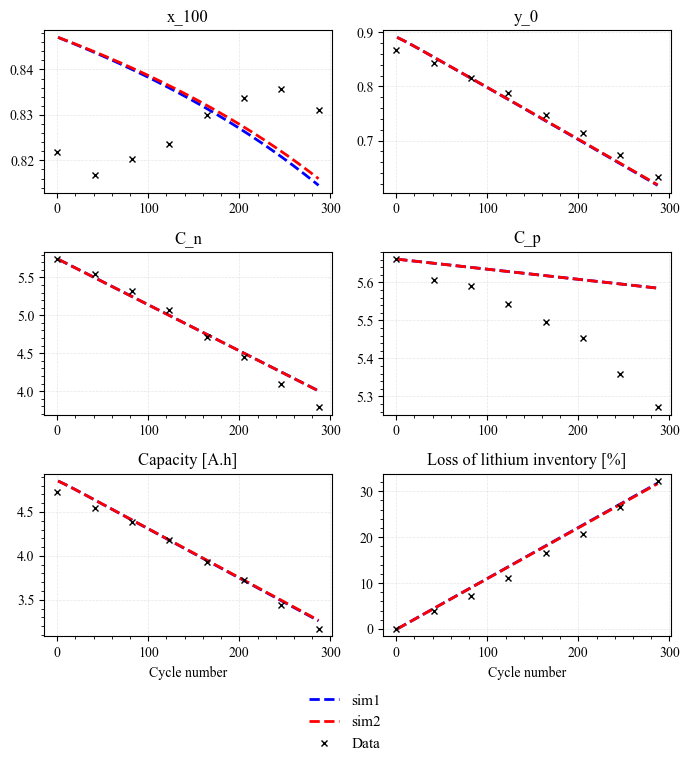

In [18]:
plotc2(all_sumvars_dict1,all_sumvars_dict2,dfe);